# Setting up


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
# import talib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu126
True


In [7]:
sp500 = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
sp500.set_index('Date', inplace=True)
ibm = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
ibm.set_index('Date', inplace=True)

In [8]:
data = sp500
data

,Close,High,Low,Open
Date,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951
...,...,...,...,...
2025-04-23,5375.859863,5469.689941,5356.169922,5395.919922
2025-04-24,5484.770020,5489.399902,5371.959961,5381.379883
2025-04-25,5525.209961,5528.109863,5455.859863,5489.729980


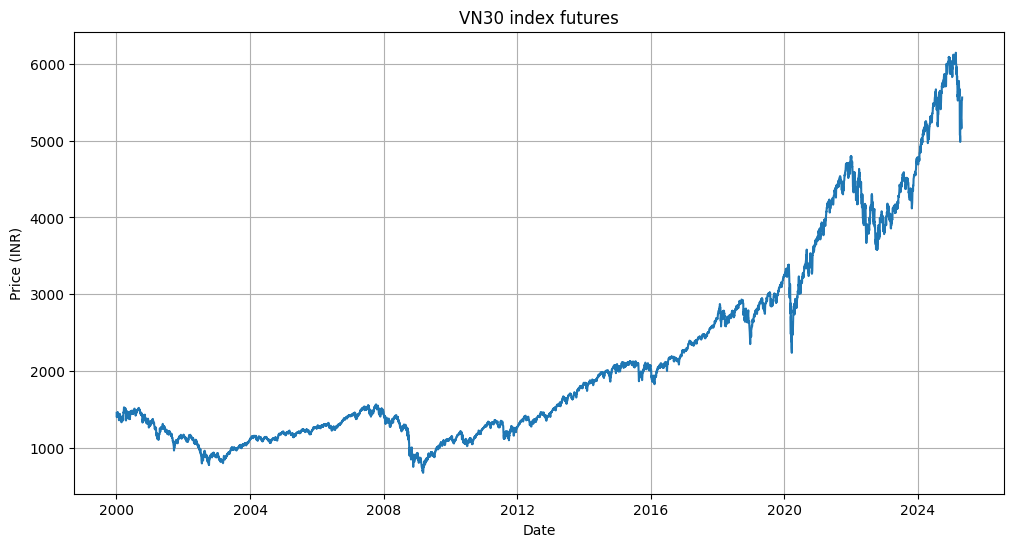

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title("VN30 index futures")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [10]:
# timestamps = preprocesssed_data['Timestamp']

# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_14', "MACD_Signal_12_26_9", "RSI_14"]
features = ['Open', 'High', 'Low', 'Close']
X_data = data[features]

In [11]:
X_data

,Open,High,Low,Close
Date,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971
...,...,...,...,...
2025-04-23,5395.919922,5469.689941,5356.169922,5375.859863
2025-04-24,5381.379883,5489.399902,5371.959961,5484.770020
2025-04-25,5489.729980,5528.109863,5455.859863,5525.209961


In [12]:
X_data = X_data.dropna()
# timestamps = timestamps[X_data.index]

X_data = X_data.values

In [13]:
seq_length = 30
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Dự đoán giá Close
    return np.array(X), np.array(y)

# X, y = create_sequences(X_scaled, seq_length)
# timestamps = timestamps[seq_length:].reset_index(drop=True)

In [14]:
split_num = int(len(X_data)*0.9)
train_data, test_data = X_data[:split_num], X_data[split_num:]

In [15]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [16]:
X_tr, y_tr = create_sequences(train_data, seq_length)
train_size = int(len(train_data) * 0.8)
X_train, X_valid = X_tr[:train_size], X_tr[train_size:]
y_train, y_valid = y_tr[:train_size], y_tr[train_size:]
# test_timestamps = timestamps[train_size:]

# Chuyển sang tensor
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)  # Thêm chiều cho đầu ra
X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid).unsqueeze(1)

In [17]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes=[800], dropout=0.1):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        # self.dropout1 = nn.Dropout(dropout)
        # self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        # self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_sizes[0], 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        # out = self.relu(out)
        # out = self.dropout1(out)
        # out, _ = self.lstm2(out)
        # out = self.relu(out)
        # out = self.dropout2(out)
        out = self.fc(out[:, -1, :])  # Chỉ lấy đầu ra của bước thời gian cuối cùng
        return out

In [19]:
input_size = len(features)  # Số lượng đặc trưng
# input_size = 8
model = LSTMModel(input_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IndexError: list index out of range

In [ ]:
device

device(type='cuda')

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

# Huấn luyện mô hình
num_epochs = 50
patience = 25
best_loss = float('inf')
patience_counter = 0

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)

    # Đánh giá trên tập kiểm tra
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            valid_loss += criterion(outputs, y_batch).item()
    valid_loss /= len(valid_loader)
    
    scheduler.step(valid_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "lstm_model.pt")
        best_valid_loss = valid_loss

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 0.002522, Valid Loss: 0.021922
Epoch [2/50], Train Loss: 0.000322, Valid Loss: 0.013166
Epoch [3/50], Train Loss: 0.000255, Valid Loss: 0.012823
Epoch [4/50], Train Loss: 0.000232, Valid Loss: 0.015311
Epoch [5/50], Train Loss: 0.000235, Valid Loss: 0.020656
Epoch [6/50], Train Loss: 0.000170, Valid Loss: 0.016615
Epoch [7/50], Train Loss: 0.000166, Valid Loss: 0.011238
Epoch [8/50], Train Loss: 0.000186, Valid Loss: 0.015302
Epoch [9/50], Train Loss: 0.000162, Valid Loss: 0.020562
Epoch [10/50], Train Loss: 0.000129, Valid Loss: 0.018750
Epoch [11/50], Train Loss: 0.000152, Valid Loss: 0.023160
Epoch [12/50], Train Loss: 0.000113, Valid Loss: 0.018993
Epoch [13/50], Train Loss: 0.000113, Valid Loss: 0.012091
Epoch [14/50], Train Loss: 0.000122, Valid Loss: 0.014424
Epoch [15/50], Train Loss: 0.000111, Valid Loss: 0.012441
Epoch [16/50], Train Loss: 0.000096, Valid Loss: 0.014620
Epoch [17/50], Train Loss: 0.000097, Valid Loss: 0.012030
Epoch [18/50], Train Lo

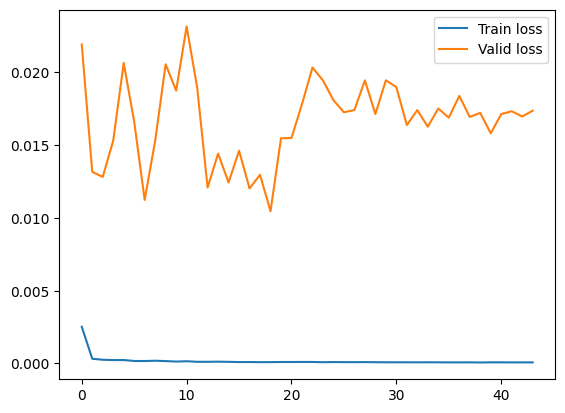

In [ ]:
plt.plot(train_losses, label = "Train loss")
plt.plot(valid_losses, label = "Valid loss")
plt.legend()
plt.show(block=False)

In [ ]:
model.load_state_dict(torch.load("lstm_model.pt"))

<All keys matched successfully>

In [ ]:
model.eval()
y_train_pred = []
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_train_pred.extend(outputs.cpu().numpy())

y_train_pred =np.array(y_train_pred)
# y_train = y_train.numpy()

model.eval()
y_valid_pred = []
with torch.no_grad():
    for X_batch, _ in valid_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_valid_pred.extend(outputs.cpu().numpy())

y_valid_pred = np.array(y_valid_pred)
# y_valid = y_valid.numpy()


# Đảo ngược chuẩn hóa
y_valid_unscaled = scaler.inverse_transform(np.concatenate((y_valid, np.zeros((len(y_valid), input_size-1))), axis=1))[:, 0]
y_valid_pred_unscaled = scaler.inverse_transform(np.concatenate((y_valid_pred, np.zeros((len(y_valid_pred), input_size-1))), axis=1))[:, 0]
y_train_unscaled = scaler.inverse_transform(np.concatenate((y_train, np.zeros((len(y_train), input_size-1))), axis=1))[:, 0]
y_train_pred_unscaled = scaler.inverse_transform(np.concatenate((y_train_pred, np.zeros((len(y_train_pred), input_size-1))), axis=1))[:, 0]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
rmse = np.sqrt(mean_squared_error(y_valid_unscaled, y_valid_pred_unscaled))
mape = mean_absolute_percentage_error(y_valid_unscaled, y_valid_pred_unscaled)
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')


RMSE: 422.1460637570063
MAPE: 0.06967961555812056


In [ ]:
torch.save(model.state_dict(), "lstm_model.pt")

In [ ]:
data['Close']

Date
2000-01-03    1455.219971
2000-01-04    1399.420044
2000-01-05    1402.109985
2000-01-06    1403.449951
2000-01-07    1441.469971
                 ...     
2025-04-23    5375.859863
2025-04-24    5484.770020
2025-04-25    5525.209961
2025-04-28    5528.750000
2025-04-29    5560.830078
Name: Close, Length: 6369, dtype: float64

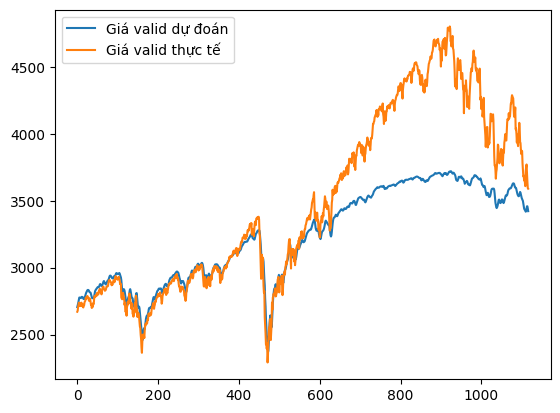

In [ ]:
plt.plot(y_valid_pred_unscaled, label = "Giá valid dự đoán")
plt.plot(y_valid_unscaled, label = "Giá valid thực tế")
plt.legend()
plt.show(block=False)

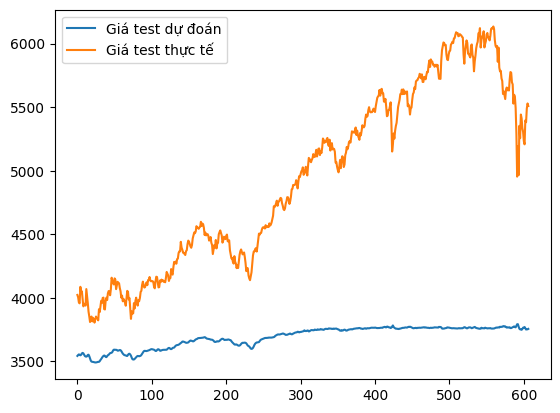

In [ ]:
X_test, y_test = create_sequences(test_data, seq_length)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model.eval()
y_test_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_test_pred.extend(outputs.cpu().numpy())

y_test_pred = np.array(y_test_pred)
y_test = y_test.numpy()


# Đảo ngược chuẩn hóa
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test, np.zeros((len(y_test), input_size-1))), axis=1))[:, 0]
y_test_pred_unscaled = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((len(y_test_pred), input_size-1))), axis=1))[:, 0]

plt.plot(y_test_pred_unscaled, label = "Giá test dự đoán")
plt.plot(y_test_unscaled, label = "Giá test thực tế")
plt.legend()
plt.show(block=False)

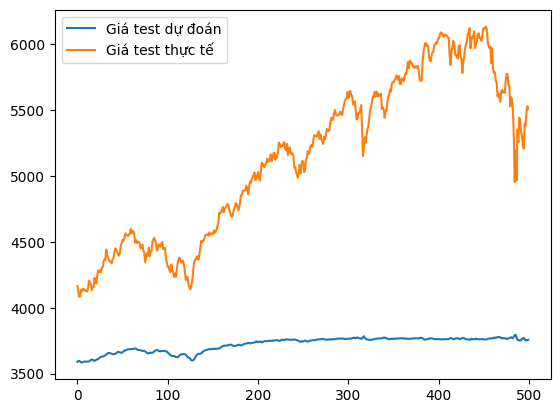

In [ ]:
plt.plot(y_test_pred_unscaled[-500:], label = "Giá test dự đoán")
plt.plot(y_test_unscaled[-500:], label = "Giá test thực tế")
plt.legend()
plt.show(block=False)